<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Logo_UNIR.png" width="350" height="175">

# *TFM: Comparación y optimización de algoritmos de Machine Learning sobre el éxito de campañas de marketing bancarias*

Autor: ***Jorge López Pérez***

***

## ***5. Tratamiento de outliers***

A lo largo de este cuaderno, veremos las diferentes posibilidades que tenemos a la hora de detectar y tratar los datos atípicos (outliers)

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
import time

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

#metricas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#imputers
from sklearn.impute import KNNImputer

#outliers tools
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

warnings.filterwarnings("ignore")

In [ ]:
# leemos los datos limpios
data = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/clean_data.csv')
data.shape

(41176, 21)

Separamos los datos en train y test que utilizaremos hasta el final del estudio (utilizaremos stratify para tener el mismo porcentaje de instancias de cada clase en train y test):

In [ ]:
x,y = data.drop(['y'], axis=1), data['y'].copy()
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, stratify=y, random_state=44)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(34999, 20)
(34999,)
(6177, 20)
(6177,)


***

#### 5.1 Pipeline

In [ ]:
numericas = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categoricas_nominal = ['job','marital', 'poutcome']
categoricas_ordinal = ['education', 'month', 'day_of_week']
categoricas_dicotomicas = ['default', 'housing', 'loan', 'contact']
total_columns = categoricas_ordinal + categoricas_nominal + categoricas_dicotomicas + numericas

def round_imputed_values(X):
    X_rounded = np.round(X)
    return X_rounded

cat_ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder(categories=[
         ["basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree"],
         ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
         ["mon","tue","wed","thu","fri"]]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('imputer', KNNImputer(n_neighbors=10)),
    ('rounding', FunctionTransformer(round_imputed_values))
])

cat_nominal_transformer = Pipeline([
     ('encoder_prev', OrdinalEncoder(categories=[
         ['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student'],
         ['married', 'single', 'divorced'],
         ['nonexistent', 'failure', 'success']
         ]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('imputer', KNNImputer(n_neighbors=10)),
     ('rounding', FunctionTransformer(round_imputed_values)),
     ('encoder', OneHotEncoder())
])

cat_dicotomico_transformer = Pipeline([
     ('encoder_prev', OrdinalEncoder(categories=[
         ['no', 'yes'],
         ['no', 'yes'],
         ['no', 'yes'],
         ['cellular', 'telephone']
         ]
     , handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('imputer', KNNImputer(n_neighbors=10)),
     ('rounding', FunctionTransformer(round_imputed_values)),
     ('encoder', OneHotEncoder())
])


preprocessor = ColumnTransformer([
        ('cat_ordinal', cat_ordinal_transformer, categoricas_ordinal),
        ('cat_nominal', cat_nominal_transformer, categoricas_nominal),
        ('cat_dicotomico', cat_dicotomico_transformer, categoricas_dicotomicas),
    ], remainder='passthrough')

pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

In [ ]:
label_encoder = LabelEncoder()
y_train_prepared = label_encoder.fit_transform(y_train)
y_test_prepared = label_encoder.transform(y_test)
print(y_train_prepared.shape)
print(y_test_prepared.shape)

(34999,)
(6177,)


In [ ]:
x_train_prepared = pipeline.fit_transform(x_train)
x_test_prepared = pipeline.transform(x_test)
print(x_train_prepared.shape)
print(x_test_prepared.shape)

(34999, 38)
(6177, 38)


***

#### 5.2 Modelos

In [ ]:
def build_rn():
  inputs = keras.Input(shape=(x_train_prepared.shape[1],))

  hidden1 = keras.layers.Dense(32, activation='relu')(inputs)
  hidden2 = keras.layers.Dense(16, activation='relu')(hidden1)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden2)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [ ]:
def initialize_models():

  estimators = [
      ('lr', LogisticRegression(random_state=44)),
      ('dt', DecisionTreeClassifier(random_state=44)),
      ('kn', KNeighborsClassifier()),
      ('rn', KerasClassifier(model=build_rn, epochs=10, batch_size=32, verbose=0, random_state=44)),
      ('rf', RandomForestClassifier(random_state=44)),
      ('xgb', xgboost.XGBClassifier(random_state=44)),
      ('hist', HistGradientBoostingClassifier(random_state=44))
  ]

  dict_estimators = dict(estimators)

  voting = VotingClassifier(estimators=estimators, voting='soft')
  dict_estimators['voting'] = voting

  return dict_estimators

***

#### 5.3 Detección de outliers

In [ ]:
def cv_original_distribution(x, y, preds_outliers):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)
  modelos = initialize_models()
  modelos.popitem() #quitamos el voting, ya que nos valdrá con el resto de modelos para saber cuál es el mejor umbral
  scores = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    preds_outliers_train = preds_outliers[train_idx]

    X_train = X_train[preds_outliers_train == 1]
    Y_train = Y_train[preds_outliers_train == 1]

    scores_fold = []
    for key, model in modelos.items():
      model.fit(X_train, Y_train)
      preds_test = model.predict_proba(X_test)[:,1]
      score = average_precision_score(Y_test, preds_test)
      scores_fold.append(score)

    scores.append(np.mean(scores_fold))

  return np.mean(scores)

In [ ]:
def umbral_optimo(detector):
  it = 1
  max_score = 0
  for i in range(1,10,1): #del 0.1% al 1% de contamination
    contamination = i/1000
    if (detector == 'isolation'): outlier_detector = IsolationForest(random_state=44, contamination=contamination)
    else: outlier_detector = LocalOutlierFactor(contamination=contamination)

    preds_outliers = outlier_detector.fit_predict(x_train_prepared)

    score = cv_original_distribution(x_train_prepared, y_train_prepared, preds_outliers)
    print('iteracion: ', it, ' -> AUC PR: ', score, ', contamination: ', contamination)
    it = it + 1
    if (score > max_score):
      max_score = score
      best_contamination = contamination
      print('*** Nuevo mejor AUC PR encontrado: ', max_score, ' con contamination: ', best_contamination, ' ***')

***

##### ***5.3.1 IsolationForest***

(1: muestras normales; -1:outliers)

In [ ]:
outlier_detector = IsolationForest(random_state=44, contamination='auto')
preds_outliers_isolation = outlier_detector.fit_predict(x_train_prepared)
print('Número de outliers sin ajustar umbral: ', preds_outliers_isolation[preds_outliers_isolation == -1].shape[0])

Número de outliers sin ajustar umbral:  6748


In [ ]:
pd.DataFrame(y_train_prepared[preds_outliers_isolation == -1]).value_counts()

0    4955
1    1793
Name: count, dtype: int64

(de los outliers identificados: 4955 instancias negativas y 1793 positivas)

Buscamos mejor umbral:

In [ ]:
umbral_optimo('isolation')

iteracion:  1  -> AUC PR:  0.5607660009379055 , contamination:  0.001
*** Nuevo mejor AUC PR encontrado:  0.5607660009379055  con contamination:  0.001  ***
iteracion:  2  -> AUC PR:  0.5610132859624574 , contamination:  0.002
*** Nuevo mejor AUC PR encontrado:  0.5610132859624574  con contamination:  0.002  ***
iteracion:  3  -> AUC PR:  0.5578766887949479 , contamination:  0.003
iteracion:  4  -> AUC PR:  0.5614513130755665 , contamination:  0.004
*** Nuevo mejor AUC PR encontrado:  0.5614513130755665  con contamination:  0.004  ***
iteracion:  5  -> AUC PR:  0.5601809929601376 , contamination:  0.005
iteracion:  6  -> AUC PR:  0.5601705111520122 , contamination:  0.006
iteracion:  7  -> AUC PR:  0.5588345496099864 , contamination:  0.007
iteracion:  8  -> AUC PR:  0.5600301787895436 , contamination:  0.008
iteracion:  9  -> AUC PR:  0.5589014332662412 , contamination:  0.009


In [ ]:
outlier_detector = IsolationForest(random_state=44, contamination=0.004)
preds_outliers_isolation_ajustado = outlier_detector.fit_predict(x_train_prepared)
print('Número de outliers ajustando umbral: ', preds_outliers_isolation_ajustado[preds_outliers_isolation_ajustado == -1].shape[0])

Número de outliers ajustando umbral:  140


In [ ]:
pd.DataFrame(y_train_prepared[preds_outliers_isolation_ajustado == -1]).value_counts()

1    99
0    41
Name: count, dtype: int64

***

##### ***5.3.2 LocalOutlierFactor***

(1: muestras normales; -1:outliers)

In [ ]:
outlier_detector = LocalOutlierFactor(contamination='auto')
preds_outliers_lof = outlier_detector.fit_predict(x_train_prepared)
print('Número de outliers sin ajustar umbral: ', preds_outliers_lof[preds_outliers_lof == -1].shape[0])

Número de outliers sin ajustar umbral:  375


In [ ]:
pd.DataFrame(y_train_prepared[preds_outliers_lof == -1]).value_counts()

0    304
1     71
Name: count, dtype: int64

In [ ]:
umbral_optimo('lof')

iteracion:  1  -> AUC PR:  0.5605520095671241 , contamination:  0.001
*** Nuevo mejor AUC PR encontrado:  0.5605520095671241  con contamination:  0.001  ***
iteracion:  2  -> AUC PR:  0.561058780852146 , contamination:  0.002
*** Nuevo mejor AUC PR encontrado:  0.561058780852146  con contamination:  0.002  ***
iteracion:  3  -> AUC PR:  0.5602234161239965 , contamination:  0.003
iteracion:  4  -> AUC PR:  0.5597209973025931 , contamination:  0.004
iteracion:  5  -> AUC PR:  0.5604391323607296 , contamination:  0.005
iteracion:  6  -> AUC PR:  0.560978916416462 , contamination:  0.006
iteracion:  7  -> AUC PR:  0.5605282231057995 , contamination:  0.007
iteracion:  8  -> AUC PR:  0.5599777367038373 , contamination:  0.008
iteracion:  9  -> AUC PR:  0.5604117635228517 , contamination:  0.009


In [ ]:
outlier_detector = LocalOutlierFactor(contamination=0.002)
preds_outliers_lof_ajustado = outlier_detector.fit_predict(x_train_prepared)
print('Número de outliers ajustando umbral: ', preds_outliers_lof_ajustado[preds_outliers_lof_ajustado == -1].shape[0])

Número de outliers ajustando umbral:  70


In [ ]:
pd.DataFrame(y_train_prepared[preds_outliers_lof_ajustado == -1]).value_counts()

0    61
1     9
Name: count, dtype: int64

***

Representación outliers-intliers tras aplicar PCA de 3 componentes:

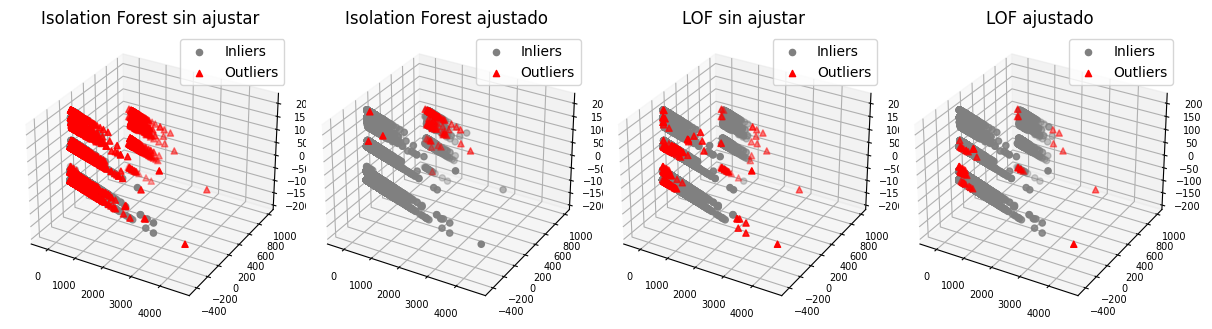

In [ ]:
preds_outliers_list = [preds_outliers_isolation, preds_outliers_isolation_ajustado, preds_outliers_lof, preds_outliers_lof_ajustado]
titles = ['Isolation Forest sin ajustar', 'Isolation Forest ajustado', 'LOF sin ajustar', 'LOF ajustado']

pca = PCA(n_components=3, random_state=44)
x_train_prepared_pca = pca.fit_transform(x_train_prepared)
fig = plt.figure(figsize=(12, 12))

for i, preds_outliers in enumerate(preds_outliers_list):
    ax = fig.add_subplot(1, 4, i + 1, projection='3d', computed_zorder=False)

    outliers = x_train_prepared_pca[preds_outliers == -1]
    inliers = x_train_prepared_pca[preds_outliers == 1]

    outliers_df = pd.DataFrame(outliers, columns=['x1', 'x2', 'x3'])
    inliers_df = pd.DataFrame(inliers, columns=['x1', 'x2', 'x3'])

    ax.scatter(inliers_df['x1'],
               inliers_df['x2'],
               inliers_df['x3'],
               c='grey', label='Inliers', marker='o', zorder=1)
    ax.scatter(outliers_df['x1'],
               outliers_df['x2'],
               outliers_df['x3'],
               c='red', label='Outliers', marker='^', zorder=2)


    ax.set_title(titles[i])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.tick_params(axis='z', labelsize=7)
    ax.legend()

plt.tight_layout()
plt.show()

***

#### 5.4 Métricas

In [ ]:
def probas_to_abs(probas, umbral=0.5):
  abs = []
  for proba in probas:
    if (proba >= umbral): abs.append(1)
    else: abs.append(0)
  return abs

def calculate_cv_metrics(estimator,x,y, predictions_outliers):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []
  scores_accuracy = []
  scores_roc = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    predictions_outliers_train = predictions_outliers[train_idx]

    X_train = X_train[predictions_outliers_train == 1]
    Y_train = Y_train[predictions_outliers_train == 1]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))
    scores_precision.append(precision_score(Y_test, probas_to_abs(preds_test)))
    scores_recall.append(recall_score(Y_test, probas_to_abs(preds_test)))
    scores_f1.append(f1_score(Y_test, probas_to_abs(preds_test)))
    scores_accuracy.append(accuracy_score(Y_test, probas_to_abs(preds_test)))
    scores_roc.append(roc_auc_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)
  mean_precision = round(np.mean(scores_precision), 4)
  mean_recall = round(np.mean(scores_recall), 4)
  mean_f1 = round(np.mean(scores_f1), 4)
  mean_accuracy = round(np.mean(scores_accuracy), 4)
  mean_roc = round(np.mean(scores_roc), 4)

  return mean_auc_pr, mean_precision, mean_recall, mean_f1, mean_accuracy, mean_roc


def calculate_pr_cv(predictions_outliers):
  modelos = initialize_models()
  scores = []
  for key, model in modelos.items():
      score,_,_,_,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared, predictions_outliers=predictions_outliers)
      scores.append(score)
      print(f'CV -> AUC PR score for {key}: ', score)
  print('')
  print('Mean AUC PR score: ', round(np.mean(scores), 4))


def calculate_baseline_metrics_cv(predictions_outliers):
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared, predictions_outliers=predictions_outliers)
      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print('')
      print('**********************************')
      print('')

***

#### 5.5 Opciones de tratamiento de outliers

***OPCIÓN 1: ISOLATION FOREST (contamination='auto')***

In [ ]:
calculate_pr_cv(predictions_outliers=preds_outliers_isolation)

CV -> AUC PR score for lr:  0.4071
CV -> AUC PR score for dt:  0.2873
CV -> AUC PR score for kn:  0.4655
CV -> AUC PR score for rn:  0.5149
CV -> AUC PR score for rf:  0.5824
CV -> AUC PR score for xgb:  0.5834
CV -> AUC PR score for hist:  0.6059
CV -> AUC PR score for voting:  0.5962

Mean AUC PR score:  0.5053


***OPCIÓN 2: ISOLATION FOREST (contamination optimizado)***

In [ ]:
calculate_pr_cv(predictions_outliers=preds_outliers_isolation_ajustado)

CV -> AUC PR score for lr:  0.5764
CV -> AUC PR score for dt:  0.3211
CV -> AUC PR score for kn:  0.4971
CV -> AUC PR score for rn:  0.5723
CV -> AUC PR score for rf:  0.6436
CV -> AUC PR score for xgb:  0.6496
CV -> AUC PR score for hist:  0.6699
CV -> AUC PR score for voting:  0.6547

Mean AUC PR score:  0.5731


***OPCIÓN 3: LOCAL OUTLIER FACTOR (contamination='auto')***

In [ ]:
calculate_pr_cv(predictions_outliers=preds_outliers_lof)

CV -> AUC PR score for lr:  0.5775
CV -> AUC PR score for dt:  0.3185
CV -> AUC PR score for kn:  0.4957
CV -> AUC PR score for rn:  0.5731
CV -> AUC PR score for rf:  0.6438
CV -> AUC PR score for xgb:  0.6427
CV -> AUC PR score for hist:  0.6658
CV -> AUC PR score for voting:  0.6452

Mean AUC PR score:  0.5703


***OPCIÓN 4: LOCAL OUTLIER FACTOR (contamination optimizado)***

In [ ]:
calculate_pr_cv(predictions_outliers=preds_outliers_lof_ajustado)

CV -> AUC PR score for lr:  0.575
CV -> AUC PR score for dt:  0.3206
CV -> AUC PR score for kn:  0.4967
CV -> AUC PR score for rn:  0.5754
CV -> AUC PR score for rf:  0.6429
CV -> AUC PR score for xgb:  0.6467
CV -> AUC PR score for hist:  0.6701
CV -> AUC PR score for voting:  0.6474

Mean AUC PR score:  0.5718


***

#### 5.6 Métricas CV mejor opción (OPCIÓN 2)

In [ ]:
calculate_baseline_metrics_cv(predictions_outliers=preds_outliers_isolation_ajustado)

CV -> AUC PR score for lr:  0.5764
CV -> Precision score for lr:  0.6636
CV -> Recall score for lr:  0.3936
CV -> F1 score for lr:  0.4937

**********************************

CV -> AUC PR score for dt:  0.3211
CV -> Precision score for dt:  0.5129
CV -> Recall score for dt:  0.5204
CV -> F1 score for dt:  0.5166

**********************************

CV -> AUC PR score for kn:  0.4971
CV -> Precision score for kn:  0.6001
CV -> Recall score for kn:  0.4877
CV -> F1 score for kn:  0.5379

**********************************

CV -> AUC PR score for rn:  0.5723
CV -> Precision score for rn:  0.5494
CV -> Recall score for rn:  0.5409
CV -> F1 score for rn:  0.4063

**********************************

CV -> AUC PR score for rf:  0.6436
CV -> Precision score for rf:  0.6546
CV -> Recall score for rf:  0.5019
CV -> F1 score for rf:  0.5679

**********************************

CV -> AUC PR score for xgb:  0.6496
CV -> Precision score for xgb:  0.6428
CV -> Recall score for xgb:  0.5293
CV -> F1 

***